# Convolutional Neural Networks Part 2:

 - Methods To Handle Overfitting

### 3rd Method: Batch Normalization With Data Augmentation:

#### Turn Off Messages:

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Fix: UnknownError: Failed to get convolution algorithm. 
# This is probably because cuDNN failed to initialize, 
# so try looking to see if a warning log message was printed above
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

#### Check GPU Availibility & Set Memory Limit:

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)]) # Alt: 1792 MB, 2048 MB
    except RuntimeError as e:
        print(e)

tf.config.list_physical_devices('GPU')

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### Import Libraries:

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from random import randint
from tensorflow.keras import layers, regularizers
from keras.models import Sequential, load_model
from keras.datasets import cifar10
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from keras.applications.vgg16 import preprocess_input
from keras.layers import Dense, Conv2D, Flatten, Dropout, Activation, MaxPooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score

#### Define Functions For Plotting:

In [4]:
# plot training accuracy and loss
def plotCurve(trainingAccuracy, trainingLoss):
    epochs = np.arange(trainingLoss.shape[0])
    #print(epochs)
    plt.figure(figsize = [12, 6])
    plt.subplot(1, 2, 1)
    plt.plot(epochs, trainingAccuracy)
    #plt.axis([-1, 2, -1, 2])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, trainingLoss)
    plt.xlabel('Epoch')
    plt.ylabel('Binary CrossEntropy Loss')
    plt.title('Training Loss')
    plt.show()

# Plot Features of CIFAR-10 data
def feat_plot(features, labels, classes, title):
    for class_i in classes:
        plt.plot(features[labels[:] == classes[class_i], 0],
                 features[labels[:] == classes[class_i], 1], 'o', markersize = 5)
        # plt.axis([-2, 2, -2, 2])
        plt.xlabel('X: Feature 1')
        plt.ylabel('Y: Feature 2')
        plt.title(title)
        plt.legend(['Class ' + str(classes[class_i]) for class_i in classes])
    plt.show()

def plotBothCurves(trainingAccuracy, trainingLoss, validAccuracy, validLoss):
    epochs = np.arange(trainingLoss.shape[0])
    epochsSaved = np.arange(validLoss.shape[0])
    #print(epochs)
    # 1st Subplot: Accuracy
    plt.figure(figsize = [12, 6])
    plt.subplot(1, 2, 1)
    plt.plot(epochs, trainingAccuracy)
    plt.plot(epochsSaved, validAccuracy) # Saved Best Value
    plt.legend(['Training', 'Validation'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    # 2nd Subplot: Training Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, trainingLoss)
    plt.plot(epochsSaved, validLoss)
    plt.legend(['Training', 'Validation'])
    plt.xlabel('Epoch')
    plt.ylabel('Binary CrossEntropy Loss')
    plt.title('Training Loss')
    plt.show()

# Plot CIFAR-10 Data In Subplots
def img_plt(img, label):
    plt.figure(figsize=(12, 5.5))
    for i in range (1, 11):
        plt.subplot(2, 5, i)
        plt.imshow(img[i - 1, :, :], cmap = 'gray')
        plt.title('Label: ' + str(label[i - 1]))
    plt.show()

def plotEverything(model_hist):
    trainAcc = np.array(model_hist.history['accuracy'])
    trainLoss = np.array(model_hist.history['loss'])
    validAcc = np.array(model_hist.history['val_accuracy'])
    validLoss = np.array(model_hist.history['val_loss'])

    plotBothCurves(trainAcc, trainLoss, validAcc, validLoss)

    trainScore = [trainAcc[-1], trainLoss[-1]]
    print(f'\nTraining Accuracy: {round(trainScore[0], 5) * 100} %')
    print(f'Training Loss: {round(trainScore[1], 4)}\n')

    valScore = [validAcc[-1], validLoss[-1]]
    print(f'\nValidation Accuracy: {round(valScore[0], 5) * 100} %')
    print(f'Validation Loss: {round(valScore[1], 4)}\n')

#### Import Data:

 - Each of the 50,000 Images is 32 x 32 pixels x 3 RGB values
     - Each Image is 3D.

In [5]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

classes = np.arange(10)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


#### Randomize & Select 20% of Images For Validation:

In [6]:
num_train_img = x_train.shape[0]
train_ind = np.arange(0, num_train_img)
train_ind_s = np.random.permutation(train_ind)
print(train_ind)
print(train_ind_s, '\n')

x_train = x_train[train_ind_s,:,:,:]
y_train = y_train[train_ind_s]
print(x_train.shape)
print(y_train.shape, '\n')

x_val = x_train[0:int(0.2 * num_train_img),:,:,:]
y_val = y_train[0:int(0.2 * num_train_img)]
print(x_val.shape)
print(y_val.shape, '\n')

x_train = x_train[int(0.2 * num_train_img):,:,:]
y_train = y_train[int(0.2 * num_train_img):]
print(x_train.shape)
print(y_train.shape, '\n')

[    0     1     2 ... 49997 49998 49999]
[23919 36010 46101 ... 11939 22736 14372] 

(50000, 32, 32, 3)
(50000, 1) 

(10000, 32, 32, 3)
(10000, 1) 

(40000, 32, 32, 3)
(40000, 1) 



#### Plot 1st 10 Images From Randomized Data:

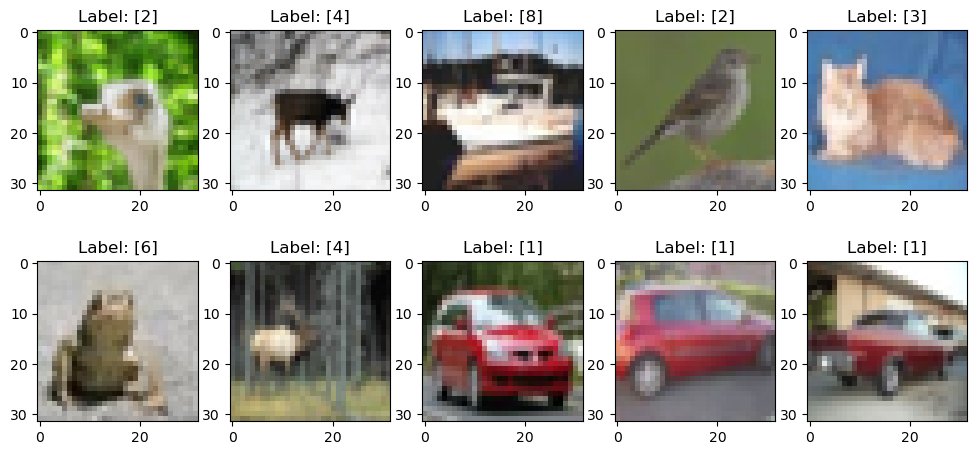

In [7]:
img_plt(x_train[0:10,:,:,:], y_train[0:10]) # plot the images

#### Scaling The Images to $ [0, \ 1] $:

In [8]:
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_val /= 255
x_test /= 255

#### Convert Class Vectors to Binary Class Matrices:

In [9]:
y_train_c = to_categorical(y_train, len(classes))
y_val_c = to_categorical(y_val, len(classes))
y_test_c = to_categorical(y_test, len(classes))

#### Define The Model With Normalization Layers:

In [10]:
model6 = Sequential()
model6.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', input_shape=x_train.shape[1:], use_bias=False))
model6.add(BatchNormalization())
model6.add(Activation('relu'))
model6.add(Conv2D(32, (3, 3), padding='same', use_bias=False))
model6.add(BatchNormalization())
model6.add(Activation('relu'))
model6.add(MaxPooling2D(pool_size=(2, 2))) # MaxPooling2D Layer or AveragePooling2D Layer

model6.add(Conv2D(64, (3, 3), padding='same', use_bias=False))
model6.add(BatchNormalization())
model6.add(Activation('relu'))
model6.add(Conv2D(64, (3, 3), padding='same', use_bias=False))
model6.add(BatchNormalization())
model6.add(Activation('relu'))
model6.add(MaxPooling2D(pool_size=(2, 2)))

model6.add(Flatten()) # Optional:Flattens 2D images to 1D Array
model6.add(Dense(units=512))
model6.add(BatchNormalization())
model6.add(Activation('relu'))
model6.add(Dropout(0.5)) # Helps to reduce overfitting
model6.add(Dense(units=len(classes)))
model6.add(BatchNormalization())
model6.add(Activation('softmax'))
model6.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        864       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9216      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0

#### Compile The Model:

 - Still Using Same Parameters As Model 2
 - Increase Learning Rate 10x: 0.001 to 0.01
 - Batch Size: 16
 - Create A Data Generator For Real-Time Data Augmentation

In [11]:
save_path6 = '../assets/Lecture7/model3_ckpt.h5'
callbacks_save6 = ModelCheckpoint(save_path6, monitor='val_loss', verbose=0, save_best_only=True, save_freq='epoch')

opt6 = tf.keras.optimizers.Adam(learning_rate=0.01)
model6.compile(loss='categorical_crossentropy', optimizer=opt6, metrics=['accuracy'])

datagen6 = ImageDataGenerator(
    #shear_range = -0.1,
    #zoom_range = -0.1,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

#### Compute Quantities Required For Featurewise Normalization:

 - std deviation, mean & principal components if ZCA Whitening is Applied.

In [12]:
datagen6.fit(x_train)

#### Fit The Model Using Data Generator & Batch Normalization:

Epoch 1/50
2500/2500 [==============================] - 64s 23ms/step - loss: 1.5810 - accuracy: 0.4246 - val_loss: 1.8426 - val_accuracy: 0.3894
Epoch 2/50
2500/2500 [==============================] - 44s 18ms/step - loss: 1.0766 - accuracy: 0.6215 - val_loss: 1.0300 - val_accuracy: 0.6406
Epoch 3/50
2500/2500 [==============================] - 51s 21ms/step - loss: 0.8913 - accuracy: 0.6898 - val_loss: 1.0435 - val_accuracy: 0.6465
Epoch 4/50
2500/2500 [==============================] - 44s 18ms/step - loss: 0.7804 - accuracy: 0.7304 - val_loss: 0.7273 - val_accuracy: 0.7463
Epoch 5/50
2500/2500 [==============================] - 40s 16ms/step - loss: 0.6870 - accuracy: 0.7649 - val_loss: 0.6922 - val_accuracy: 0.7669
Epoch 6/50
2500/2500 [==============================] - 42s 17ms/step - loss: 0.6019 - accuracy: 0.7911 - val_loss: 0.7310 - val_accuracy: 0.7481
Epoch 7/50
2500/2500 [==============================] - 63s 25ms/step - loss: 0.5356 - accuracy: 0.8145 - val_loss: 0.6763 -

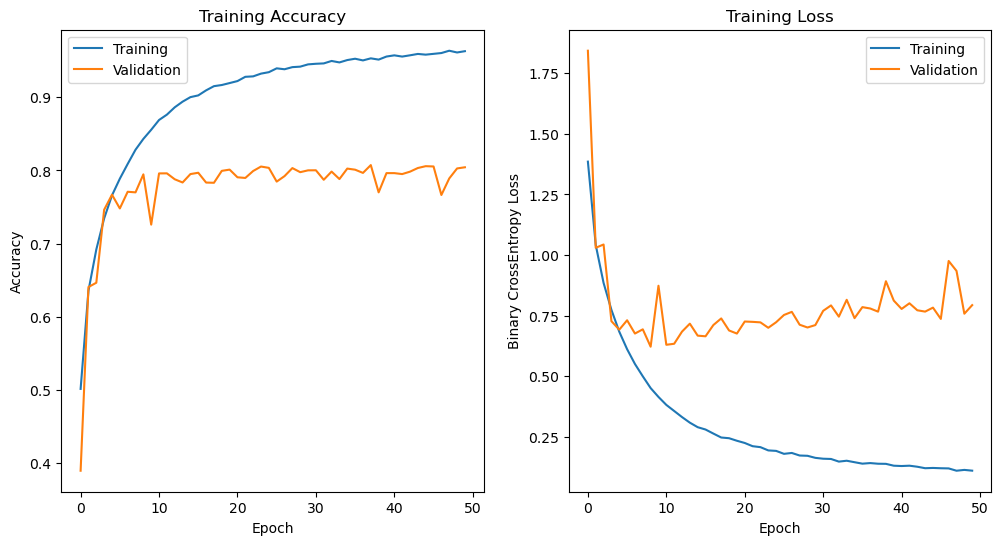


Training Accuracy: 96.317 %
Training Loss: 0.1108


Validation Accuracy: 80.44 %
Validation Loss: 0.7935



In [13]:
history6 = model6.fit(x_train, y_train_c, batch_size=16, 
                      epochs=50, verbose=1, validation_data=(x_val, y_val_c), 
                      callbacks=[callbacks_save6])

plotEverything(history6)                      

#### Load Best Model & Evaluate:

In [14]:
model6a = load_model(save_path6)

score6a = model6a.evaluate(x_train, y_train_c)
print(f'Total Loss From Training Set: {score6a[0]}')
print(f'Accuracy From Training Set: {score6a[1] * 100} %\n')

score6b = model6a.evaluate(x_val, y_val_c)
print(f'Total Loss From Validation Set: {score6b[0]}')
print(f'Accuracy From Validation Set: {score6b[1] * 100} %\n')

score6c = model6a.evaluate(x_test, y_test_c)
print(f'Total Loss From Testing Set: {score6c[0]}')
print(f'Accuracy From Testing Set: {score6c[1] * 100} %\n')

1250/1250 [==============================] - 11s 6ms/step - loss: 0.1935 - accuracy: 0.9469
Total Loss From Training Set: 0.19349676370620728
Accuracy From Training Set: 94.69249844551086 %

313/313 [==============================] - 3s 10ms/step - loss: 0.6220 - accuracy: 0.7947
Total Loss From Validation Set: 0.6220105290412903
Accuracy From Validation Set: 79.4700026512146 %

313/313 [==============================] - 3s 10ms/step - loss: 0.6321 - accuracy: 0.7917
Total Loss From Testing Set: 0.6320996284484863
Accuracy From Testing Set: 79.1700005531311 %



#### Predict Class Of Held Out Samples:

In [15]:
test_class3_prob = model6.predict(x_test)
test_labels3 = np.argmax(test_class3_prob, axis=1)
print(f'The Accuracy Predicting The Test Set is: {accuracy_score(test_labels3, y_test) * 100} %\n')
conf_matrix3 = confusion_matrix(test_labels3, y_test)

colLabels3 = ['Pred Plane', 'Pred Car', 'Pred Bird', 'Pred Cat', 'Pred Deer',
             'Pred Dog', 'Pred Frog', 'Pred Horse', 'Pred Ship', 'Pred Truck']
rowLabels3 = ['Actual Plane', 'Actual Car', 'Actual Bird', 'Actual Cat', 'Actual Deer',
             'Actual Dog', 'Actual Frog', 'Actual Horse', 'Actual Ship', 'Actual Truck']

fancyMatrix3 = pd.DataFrame(conf_matrix3, columns=colLabels3, index=rowLabels3,)
display(fancyMatrix3)

The Accuracy Predicting The Test Set is: 79.78 %



,Pred Plane,Pred Car,Pred Bird,Pred Cat,Pred Deer,Pred Dog,Pred Frog,Pred Horse,Pred Ship,Pred Truck
Actual Plane,856,13,72,42,24,16,13,13,51,23
Actual Car,7,894,0,8,2,0,1,3,16,38
Actual Bird,28,3,715,77,69,59,60,37,8,5
Actual Cat,8,4,31,607,46,127,28,34,2,6
Actual Deer,10,0,75,58,760,37,20,55,1,5
Actual Dog,1,0,41,110,24,705,17,42,3,1
Actual Frog,6,1,35,59,42,19,851,8,2,0
Actual Horse,4,0,15,15,25,19,4,793,3,3
Actual Ship,45,15,11,11,5,13,5,4,894,16
Actual Truck,35,70,5,13,3,5,1,11,20,903
